## Install

In [1]:
!pip install langchain
!pip install langchain-chroma
!pip install -U langchain-community
!pip install tiktoken
!pip install unstructured

In [2]:
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub


In [3]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app

/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app


In [6]:
!ls

df_RAG6.csv		   MutualFundSummary6
df_RAG7.csv		   MutualFundSummary6_5
df_summary.csv		   MutualFundSummary7
docs			   MutualFundSummary8
FundArticlesHealthy.csv    MutualFundSummary9
FundArticlesUnhealthy.csv  NLP_Deep_Learning_Questrom_WS_03_2020.ipynb
MutualFundLabels.csv	   word2vec_model.pkl
MutualFundSummary	   word2vec_perso.txt
MutualFundSummary10


In [7]:
DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

HEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesHealthy.csv")
UNHEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesUnhealthy.csv")

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'
new_word2vec = 'word2vec_MutualFundSummary.txt'

In [8]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [9]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)

In [10]:
len(fund_names)

545

In [11]:
len(summaries)

545

In [12]:
fund_names[20]

'AB Municipal Bond Inflation Strategy'

In [13]:
type(summaries), type(fund_names)

(list, list)

In [14]:
df_summary = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/df_summary.csv')
df_summary

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,Ivestment_Strategy_label,Predicted investment strategy,investment strategy evidence,source meta data,Prediction
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2018 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2021 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2024 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2027 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2030 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
427,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Corporate Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0
428,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Municipal Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0
429,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,0.0,Equity Long Only (Low Risk),American Century Quality Diversified Internati...,{'source': 'MutualFundSummary/American Century...,0.0
430,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,0.0,Equity Long Only (Low Risk),American Century STOXX U.S. Quality Growth ETF...,{'source': 'MutualFundSummary/American Century...,0.0


In [15]:
common_fund_names = []
for index, name in enumerate(fund_names):
    # Check if the current fund name is in the set of common names
    if name in set(df_summary['fund_name']):
        # If it is, append the corresponding summary (using the same index)
        common_fund_names.append(fund_names[index])
len(common_fund_names)

432

In [16]:
common_summaries = []
for index, name in enumerate(fund_names):
    # Check if the current fund name is in the set of common names
    if name in set(df_summary['fund_name']):
        # If it is, append the corresponding summary (using the same index)
        common_summaries.append(summaries[index])
len(common_summaries)

432

In [17]:
#checking
common_fund_names[1]

'ALL CAP GROWTH FUND'

In [18]:
common_summaries[1]

'Fund Summary\nInvestment Objective\nThe fund seeks long-term capital growth.\nFees and Expenses\nThe following table describes the fees and expenses you may pay if you buy and hold shares of the fund. You may qualify for sales charge discounts if you and your family invest, or agree to invest in the future, at least $50,000 in American Century Investments funds. More information about these and other discounts is available from your financial professional and in Calculation of Sales Charges on page 12 of the fund’s prospectus, Appendix A of the fund’s prospectus and Sales Charges in Appendix B of the statement of additional information.\nShareholder Fees (fees paid directly from your investment)\n \n \nInvestor\nI1\nA\nC\nR\nMaximum Sales Charge (Load) Imposed on\nPurchases (as a percentage of offering price)\nNone\nNone\n5.75%\nNone\nNone\nMaximum Deferred Sales Charge (Load)\n(as a percentage of the lower of the original\noffering price or redemption proceeds when redeemed\nwithin o

## split to train, validation, test

In [19]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    common_summaries, common_fund_names, test_size=0.3, random_state=815)

In [20]:
#split to test and validation set
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42)

In [21]:
len(X_train), len(X_val), len(X_test)

(302, 65, 65)

In [25]:
y_train

['MFS Georgia Municipal Bond Fund',
 'Vanguard Short-Term Corporate Bond Index Fund',
 'Janus Henderson Enterprise Fund',
 'Anchor Tactical Credit Strategies Fund',
 'Ivy Value Fund',
 'American Funds College 2030 Fund',
 'Treasury Money Market Trust',
 'Columbia Small/Mid Cap Value Fund',
 'MainStay VP Janus Henderson Balanced Portfolio',
 'Fidelity Managed Retirement 2020 Fund',
 'American Funds 2030 Target Date Retirement Fund',
 'Franklin Payout 2019 Fund',
 'Global Growth and Income Fund',
 'Columbia Variable Portfolio - Income Opportunities Fund',
 'Portfolio Series - American Funds Managed Risk Growth Portfolio',
 'Janus Henderson Mid Cap Value Portfolio',
 'Ivy Science and Technology Fund',
 'MainStay VP S&P 500 Index Portfolio',
 'Ivy Securian Real Estate Securities Fund',
 'Managed Risk Growth-Income Fund',
 'MFS Pennsylvania Municipal Bond Fund',
 'Franklin LibertyQ Global Equity ETF',
 'Franklin FTSE Italy ETF',
 'Federated MDT Small Cap Growth Fund',
 'MFS California Munic

## Following the NLP application in class, use the skip-gram model to build a word embedding dictionary from the mutual fund prospectus in the training set

### Tokenize the text

In [27]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

In [28]:
stop_words = set(stopwords.words('english')+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [29]:
# clean and tokenize the text
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

In [30]:
#extract X_train as a list
#X_train_list = X_train.tolist()

In [31]:
#import nltk
#nltk.download('punkt')

In [32]:
#nltk.download('punkt_tab')

In [33]:
text_words = np.concatenate([tokenizer(summary) for summary in X_train])

In [34]:
text_words, text_words.size

(array(['mfs', 'georgia', 'municipal', ..., "'s", 'website', 'information'],
       dtype='<U44'),
 548107)

### Process Skip-Gram model Input

In [35]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

In [36]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [37]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [38]:
word2id = dict() #same as {}
for i, (word, _)in enumerate(count):
    word2id[word] = i
#word2id

In [39]:
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [40]:
#id2word

In [41]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 2824


In [42]:
len(word2id) #the words in'id2word and word2id is same

2824

In [43]:
# create data
data = list() #[]
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0) #if vwe cannot find the word, it will return 0 instead of having an error
    if index == 0:  #which means we could not find the word in our dictionary
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count) #update the number of 'UNK'

In [44]:
count[0]

('UNK', 9482)

In [45]:
print(data[:20]) #377 is janus

[309, 0, 119, 148, 1, 313, 1256, 31, 3, 127, 1, 3, 127, 349, 43, 28, 1292, 26, 600, 78]


In [46]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [47]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

### Train the skip-gram model

In [48]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [49]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [50]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2824)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       141,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2824)           │       144,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,274 (1.09 MB)

 Trainable params: 285,274 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2
4283/4283 ━━━━━━━━━━━━━━━━━━━━ 109s 25ms/step - loss: 0.0825
Epoch 2/2
4283/4283 ━━━━━━━━━━━━━━━━━━━━ 113s 26ms/step - loss: 0.0027


In [52]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [53]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [54]:
# We can save the word2vec dictionary to reuse it later.
#new_word2vec.to_csv('word2vec_MutualFundSummary_train.txt')

In [56]:
type(word2vec)

dict

In [57]:
import pickle
file_path_pickle = 'word2vec_model.pkl'
print(f"Saving dictionary to {file_path_pickle} using pickle...")
with open(file_path_pickle, 'wb') as f: # 'wb' means write binary
    pickle.dump(word2vec, f)
print("Saving complete.")

Saving dictionary to word2vec_model.pkl using pickle...
Saving complete.


In [58]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}

    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [59]:
words_neighbors_1 = get_n_closer('securities', 10, word2vec)
print('words close to securities : ' +str(', '.join(words_neighbors_1)))
#words_neighbors_2 = get_n_closer('equiderivativety', 10, word2vec)
#print('words close to derivative : ' +str(', '.join(words_neighbors_2)))

words close to securities : securities, quarter, choosing, fund℠, risk-adjusted, multiple, method, higher-rated, generate, honor


In [60]:
#plot closer words
# fit the TSNE dimenstion reduction model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(2824, 50)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(2824, 2)


In [61]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [62]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])

    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['fee', 'swaps'], 10, word2vec)

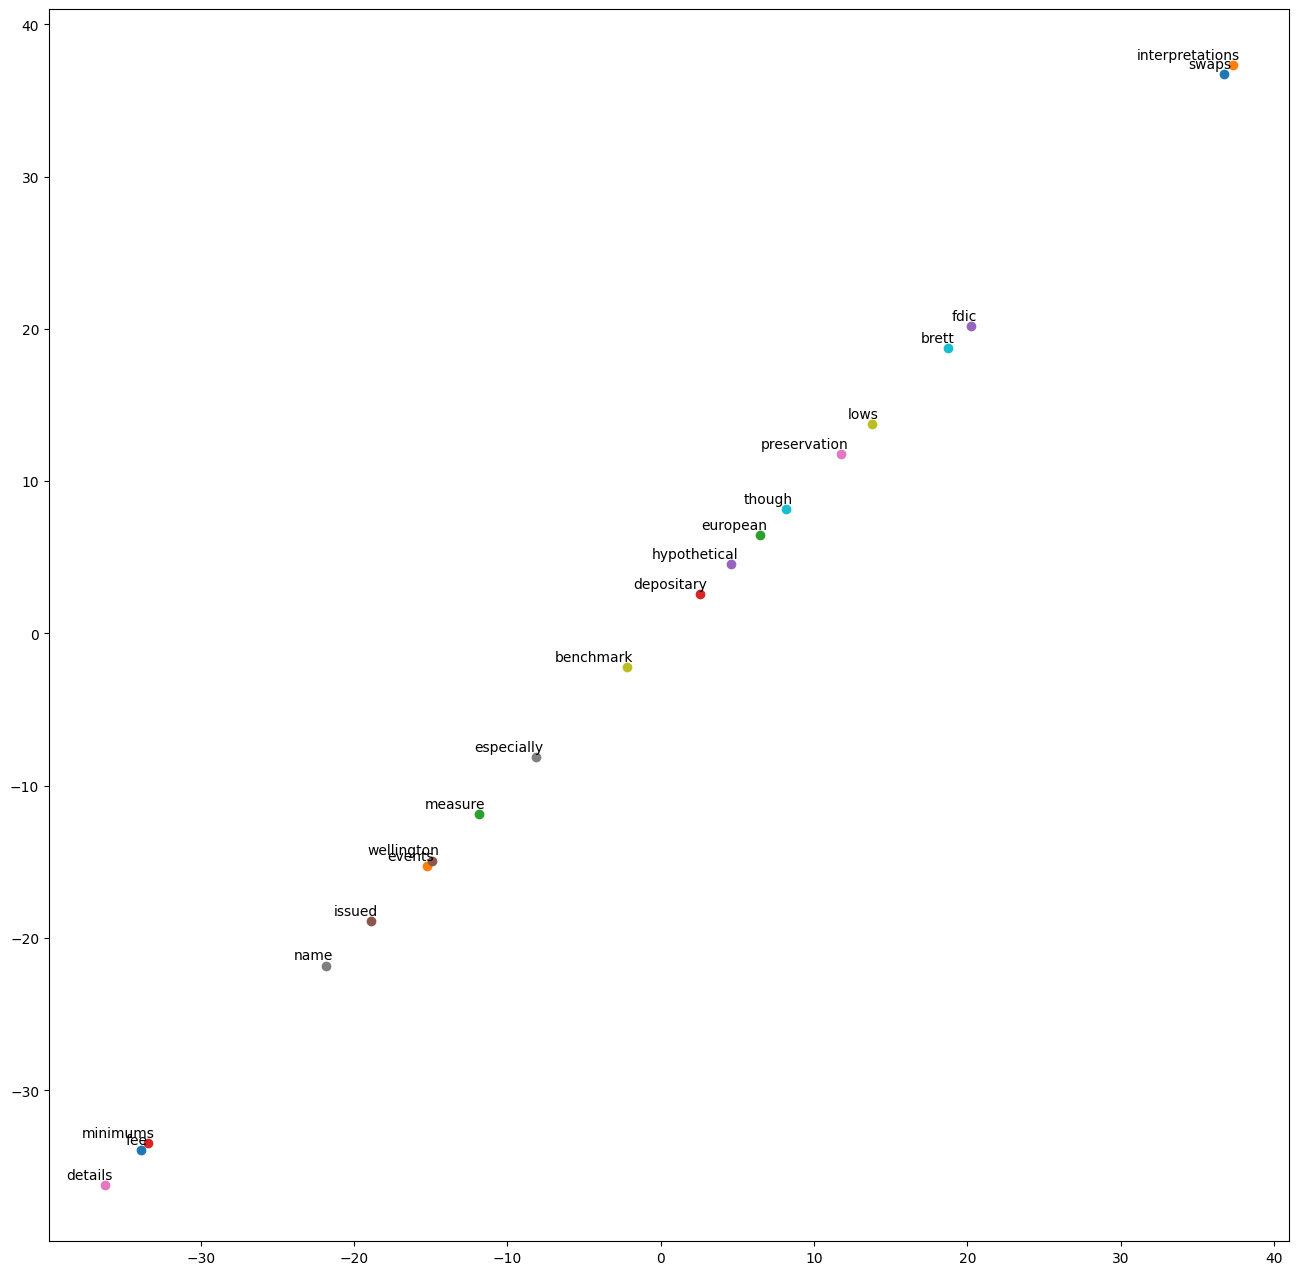

In [63]:
plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.show()

## Create a knowledge base

In [64]:
key_words = ['balanced fund', 'fixed income', 'interest', 'bond', ' long only',
             'equity', 'low', 'risk', 'strategy', 'return', 'volatility', 'stock',
             'asset', 'class','growth','rebalance','diversification','leverage',
             ]

In [65]:
#print(f"\nLoading dictionary from {file_path_pickle} using pickle...")
#with open('word2vec_model.pkl', 'rb') as f: # 'rb' means read binary
#    word2vec = pickle.load(f)
#print("Loading complete.")

In [66]:
#word2vec = load_word2vec(new_word2vec)

In [67]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [68]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base = create_knowledge_base(5, word2vec, key_words)

balanced fund not in word2vec
fixed income not in word2vec
 long only not in word2vec


In [69]:
print(knowledge_base)

{np.str_('require'), np.str_('achieved'), np.str_('james'), np.str_('higher-rated'), np.str_('magnified'), np.str_('transactions'), np.str_('central'), np.str_('highlights'), np.str_('asian'), 'volatility', np.str_('restructuring'), 'balanced fund', np.str_('restricted'), np.str_('voluntary'), np.str_('new'), 'class', np.str_('take'), 'strategy', np.str_('impossible'), np.str_('tbd'), np.str_('automated'), np.str_('unpredictable'), np.str_('holdings'), np.str_('impair'), 'bond', np.str_('reduced'), np.str_('tables'), np.str_('mo'), np.str_('issuer-specific'), 'return', np.str_('vary'), np.str_('unpredictably'), 'diversification', np.str_('largely'), np.str_('lifetime'), 'interest', 'equity', np.str_('waivers'), np.str_('proceeds'), 'low', np.str_('regarding'), np.str_('instrumentalities'), 'fixed income', np.str_('role'), np.str_('servicing'), np.str_('fewer'), ' long only', np.str_('valuations'), np.str_('salesperson'), np.str_('portion'), np.str_('would'), 'leverage', np.str_('waive'

In [70]:
items_to_remove = {'balanced fund', 'fixed income', ' long only'}
for item in items_to_remove:
    knowledge_base.discard(item)
knowledge_base

{np.str_('achieved'),
 np.str_('asian'),
 'asset',
 np.str_('automated'),
 'bond',
 np.str_('broader'),
 np.str_('capable'),
 np.str_('caused'),
 np.str_('central'),
 'class',
 np.str_('continue'),
 np.str_('default'),
 np.str_('disclosure'),
 'diversification',
 np.str_('earn'),
 np.str_('earns'),
 'equity',
 np.str_('excluding'),
 np.str_('fewer'),
 'growth',
 np.str_('higher-rated'),
 np.str_('highlights'),
 np.str_('holdings'),
 np.str_('impair'),
 np.str_('impossible'),
 np.str_('instrumentalities'),
 'interest',
 np.str_('issuer-specific'),
 np.str_('james'),
 np.str_('largely'),
 np.str_('left'),
 'leverage',
 np.str_('lifetime'),
 'low',
 np.str_('magnified'),
 np.str_('many'),
 np.str_('mo'),
 np.str_('new'),
 np.str_('perceived'),
 np.str_('portion'),
 np.str_('proceeds'),
 np.str_('r.'),
 'rebalance',
 np.str_('reduced'),
 np.str_('regarding'),
 np.str_('rennison'),
 np.str_('require'),
 np.str_('restricted'),
 np.str_('restructuring'),
 'return',
 'risk',
 np.str_('role'),


In [71]:
y_train[1]

'Vanguard Short-Term Corporate Bond Index Fund'

In [72]:
df_summary[['fund_name','Prediction']]

,fund_name,Prediction
0,American Funds College 2018 Fund,2.0
1,American Funds College 2021 Fund,2.0
2,American Funds College 2024 Fund,2.0
3,American Funds College 2027 Fund,2.0
4,American Funds College 2030 Fund,2.0
...,...,...
427,American Century Diversified Corporate Bond ETF,1.0
428,American Century Diversified Municipal Bond ETF,1.0
429,American Century Quality Diversified Internati...,0.0
430,American Century STOXX U.S. Quality Growth ETF,0.0


In [73]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction_train = pd.DataFrame({'fund_name' : y_train, 'summary':X_train})
df_label = df_summary[['fund_name','Prediction']]
df_main_train = df_label.merge(df_extraction_train, on='fund_name', how='inner')
df_main_train

,fund_name,Prediction,summary
0,American Funds College 2018 Fund,2.0,American Funds College 2018 Fund\n\nInvestment...
1,American Funds College 2021 Fund,2.0,American Funds College 2021 Fund\n\nInvestment...
2,American Funds College 2027 Fund,2.0,American Funds College 2027 Fund\n\nInvestment...
3,American Funds College 2030 Fund,2.0,American Funds College 2030 Fund\n\nInvestment...
4,American Funds College 2033 Fund,2.0,American Funds College 2033 Fund\n\nInvestment...
...,...,...,...
297,American Century Growth ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...
298,American Century Value ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...
299,American Century Diversified Corporate Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...
300,American Century Diversified Municipal Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...


In [74]:
df_label.head()

,fund_name,Prediction
0,American Funds College 2018 Fund,2.0
1,American Funds College 2021 Fund,2.0
2,American Funds College 2024 Fund,2.0
3,American Funds College 2027 Fund,2.0
4,American Funds College 2030 Fund,2.0


In [75]:
df_extraction_train.head()

,fund_name,summary
0,MFS Georgia Municipal Bond Fund,MFS Georgia Municipal Bond Fund\n\n \n\nSummar...
1,Vanguard Short-Term Corporate Bond Index Fund,Vanguard Short-Term Corporate Bond Index Fund\...
2,Janus Henderson Enterprise Fund,Janus Henderson Enterprise Fund\n(closed to ce...
3,Anchor Tactical Credit Strategies Fund,FUND SUMMARY - ANCHOR TACTICAL CREDIT STRATEGI...
4,Ivy Value Fund,Ivy Value Fund\n\nObjective\n\nTo seek to prov...


In [76]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction_val = pd.DataFrame({'fund_name' : y_val, 'summary':X_val})
df_label = df_summary[['fund_name','Prediction']]
df_main_val = df_label.merge(df_extraction_val, on='fund_name', how='inner')
df_main_val

,fund_name,Prediction,summary
0,American Funds College 2024 Fund,2.0,American Funds College 2024 Fund\n\nInvestment...
1,Bond Fund,1.0,Bond Fund\n\nInvestment objective The fund’s i...
2,Global Balanced Fund,2.0,Global Balanced Fund\n\nInvestment objectives ...
3,Global Bond Fund,1.0,Global Bond Fund\n\nInvestment objective The f...
4,Global Growth Fund,0.0,Global Growth Fund\n\nInvestment objective The...
...,...,...,...
60,Fidelity Diversified International Fund,0.0,Fund Summary\n\nFund/Class:\nFidelity® Diversi...
61,Federated MDT Balanced Fund,2.0,Fund Summary Information\nFederated MDT Balanc...
62,Managed Allocation Fund,2.0,INVESTMENT OBJECTIVE\nThe USAA Managed Allocat...
63,American Century STOXX U.S. Quality Growth ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...


In [77]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction_test = pd.DataFrame({'fund_name' : y_test, 'summary':X_test})
df_label = df_summary[['fund_name','Prediction']]
df_main_test = df_label.merge(df_extraction_test, on='fund_name', how='inner')
df_main_test

,fund_name,Prediction,summary
0,American Funds College Enrollment Fund,1.0,American Funds College Enrollment Fund\n\nInve...
1,American Funds U.S. Government Money Market Fund,1.0,Investment objective The investment objective ...
2,Global Small Capitalization Fund,0.0,Global Small Capitalization Fund\n\nInvestment...
3,Managed Risk Blue Chip Income and Growth Fund,2.0,Managed Risk Blue Chip Income and Growth Fund\...
4,New World Fund,0.0,New World Fund\n\nInvestment objective The fun...
...,...,...,...
60,Swan Defined Risk Fund,2.0,FUND SUMMARY – SWAN DEFINED RISK FUND\n\n \n\n...
61,Nasdaq-100 Index Fund,0.0,INVESTMENT OBJECTIVE\nThe USAA Nasdaq-100 Inde...
62,S&P 500 Index Fund,0.0,INVESTMENT OBJECTIVE\nThe USAA S&P 500 Index F...
63,Income Stock Fund,0.0,INVESTMENT OBJECTIVE\nThe USAA Income Stock Fu...


In [78]:
df_main_train['summary'] = df_main_train['summary'].astype(str)
df_main_val['summary'] = df_main_val['summary'].astype(str)
df_main_test['summary'] = df_main_test['summary'].astype(str)
df_main_train

,fund_name,Prediction,summary
0,American Funds College 2018 Fund,2.0,American Funds College 2018 Fund\n\nInvestment...
1,American Funds College 2021 Fund,2.0,American Funds College 2021 Fund\n\nInvestment...
2,American Funds College 2027 Fund,2.0,American Funds College 2027 Fund\n\nInvestment...
3,American Funds College 2030 Fund,2.0,American Funds College 2030 Fund\n\nInvestment...
4,American Funds College 2033 Fund,2.0,American Funds College 2033 Fund\n\nInvestment...
...,...,...,...
297,American Century Growth ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...
298,American Century Value ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...
299,American Century Diversified Corporate Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...
300,American Century Diversified Municipal Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...


In [79]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [80]:
# It takes several minutes (5-10 minutes)
df_main_train['strategy_sentences_distance'] = df_main_train.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [81]:
#def extract_sentence_match(summary, knowledge, num_sent):
#    sentences = sent_tokenize(summary)
#    sentence_scores = []
#    for j, sentence in enumerate(sentences):
#        set_tokens = set(tokenizer(sentence))
#
        # Find the number of common words between the knowledge base and the sentence
 #       inter_knwoledge = set_tokens.intersection(knowledge)
#
 #       sentence_scores.append(len(inter_knwoledge))
#
 #   sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
  #  top_sentences = sentences[len(sentences)-num_sent-1:]
   # return ' '.join(top_sentences)

In [82]:
#df_main['strategy_sentences_match'] = df_main.apply(lambda x : extract_sentence_match(x['Summary'], knowledge_base, num_sent=5), axis=1)

In [83]:
df_main_train

,fund_name,Prediction,summary,strategy_sentences_distance
0,American Funds College 2018 Fund,2.0,American Funds College 2018 Fund\n\nInvestment...,The investment adviser will also consider whet...
1,American Funds College 2021 Fund,2.0,American Funds College 2021 Fund\n\nInvestment...,The investment adviser will also consider whet...
2,American Funds College 2027 Fund,2.0,American Funds College 2027 Fund\n\nInvestment...,The investment adviser will also consider whet...
3,American Funds College 2030 Fund,2.0,American Funds College 2030 Fund\n\nInvestment...,The investment adviser will also consider whet...
4,American Funds College 2033 Fund,2.0,American Funds College 2033 Fund\n\nInvestment...,The investment adviser will also consider whet...
...,...,...,...,...
297,American Century Growth ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...,There can be no assurance that any large share...
298,American Century Value ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...,There can be no assurance that any large share...
299,American Century Diversified Corporate Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...,There can be no assurance that any large share...
300,American Century Diversified Municipal Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...,There can be no assurance that any large share...


## Information extraction using deep classifiers

In [84]:
#X = df_main['strategy_sentences_match'].values
X_train = df_main_train['strategy_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X_train = [' '.join(tokenizer(txt)) for txt in X_train]
X_train[0][:100]

'investment adviser also consider whether overall market conditions would favor change exposure fund '

In [85]:
y_train = df_main_train['Prediction']
y_train

,Prediction
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
297,0.0
298,0.0
299,1.0
300,1.0


In [86]:
y_val = df_main_val['Prediction']
y_val

,Prediction
0,2.0
1,1.0
2,2.0
3,1.0
4,0.0
...,...
60,0.0
61,2.0
62,2.0
63,0.0


In [87]:
y_test = df_main_test['Prediction']
y_test

,Prediction
0,1.0
1,1.0
2,0.0
3,2.0
4,0.0
...,...
60,2.0
61,0.0
62,0.0
63,0.0


## Data Pre-Processing

<ipython-input-88-bc141d98f3b4>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

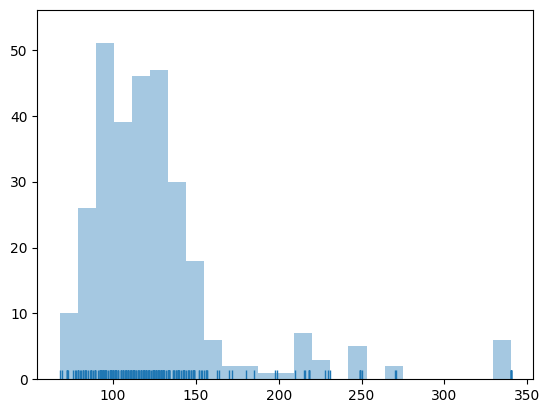

In [88]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X_train)), display_id=True)
for ii, txt in enumerate(X_train):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X_train)))

sns.distplot(sizes, kde=False, rug=True)

In [89]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 170 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [132]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_val = keras_tokenizer.texts_to_sequences(X_val)
sequences_test=keras_tokenizer.texts_to_sequences(X_test)

In [91]:
print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : investment adviser also consider whether overall market conditions would favor change exposure fund various asset types geographic regions conversely interest rates rise borrowers repay debt slowly expected time mortgage-backed asset-backed securities paid could extended reducing underlying fund cash available reinvestment higher yielding securities investors fund long-term perspective able tolerate potentially sharp declines value underlying fund counterparty derivative transaction including applicable underlying fund clearing broker derivatives exchange clearinghouse may unable unwilling honor financial obligations respect transaction market conditions prices income generated common stocks bonds securities held underlying funds may decline sometimes rapidly unpredictably due various factors including events conditions affecting general economy particular industries overall market changes local regional global political social economic instability governmental governmental agen

In [92]:
len(sequences_train)

302

In [133]:
#Then we use the pad_sequence function provided by keras to truncate or lengthen (by adding zeros)
#each text so they all have the same length : 170
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val = pad_sequences(sequences_val, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test=pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [94]:
print(len(X_train[0]))
len(feature_train[0])

1091


170

In [95]:
word2vec.get("stock")

array([-0.47310466, -0.50026137, -0.51735544,  0.4864734 ,  0.50829345,
        0.50707346,  0.49945685, -0.44656736, -0.48477575, -0.51490366,
        0.46875837,  0.5011446 , -0.4978866 , -0.5199042 , -0.46419314,
       -0.49462244,  0.44248712,  0.48310947, -0.43896547, -0.487893  ,
        0.49190804, -0.4524951 ,  0.50937986, -0.51930606, -0.4934631 ,
       -0.49373105, -0.52413905,  0.42036813, -0.44848067,  0.4654928 ,
       -0.47486424,  0.46989495, -0.47665197, -0.51484406,  0.46740353,
       -0.5033152 ,  0.45791036, -0.49456978, -0.5163607 ,  0.452488  ,
       -0.45348182, -0.42562643,  0.5100363 , -0.48822564,  0.49457633,
        0.43940857,  0.44341335, -0.5072946 ,  0.48408493,  0.5113927 ],
      dtype=float32)

In [96]:
word_index.get("investments")

39

In [98]:
X_train[0]

'investment adviser also consider whether overall market conditions would favor change exposure fund various asset types geographic regions conversely interest rates rise borrowers repay debt slowly expected time mortgage-backed asset-backed securities paid could extended reducing underlying fund cash available reinvestment higher yielding securities investors fund long-term perspective able tolerate potentially sharp declines value underlying fund counterparty derivative transaction including applicable underlying fund clearing broker derivatives exchange clearinghouse may unable unwilling honor financial obligations respect transaction market conditions prices income generated common stocks bonds securities held underlying funds may decline sometimes rapidly unpredictably due various factors including events conditions affecting general economy particular industries overall market changes local regional global political social economic instability governmental governmental agency res

In [99]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 130
length of the paded first sequence : 170


In [100]:
#matrix representation of the words in our vocabulary
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [101]:
embedding_matrix[1]

array([-0.47240174, -0.443867  , -0.46155167,  0.51059693,  0.51585394,
        0.45665658,  0.44603437, -0.51756263, -0.46518296, -0.51330251,
        0.4468683 ,  0.52326238, -0.54011095, -0.51340467, -0.51215404,
       -0.46365979,  0.43175113,  0.50758249, -0.43670917, -0.44149777,
        0.44203687, -0.48613673,  0.47639209, -0.45206407, -0.50125599,
       -0.52049035, -0.48720077,  0.48280886, -0.50135624,  0.41876838,
       -0.5135507 ,  0.4923743 , -0.47894186, -0.4654077 ,  0.42470476,
       -0.45993698,  0.43898225, -0.49511102, -0.49081871,  0.51990306,
       -0.46962687, -0.48743823,  0.4723765 , -0.42635196,  0.46388391,
        0.51391971,  0.49485594, -0.49849963,  0.52423131,  0.53077841])

In [102]:
embedding_matrix.shape

(1962, 50)

In [103]:
len(word_index) + 1

1962

In [104]:
word_dimension

50

## First model: One dimensional Convolutional Neural Network

def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 1, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return CNN

In [105]:
def create_CNN_model():
    CNN = Sequential()
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation='relu'))
    CNN.add(MaxPooling1D(pool_size=5))

    CNN.add(Convolution1D(32, 5, activation='relu'))
    CNN.add(MaxPooling1D(pool_size=5))

    CNN.add(Flatten())
    CNN.add(Dense(units=128, activation='relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units=3, activation='softmax'))

    CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return CNN

In [106]:
CNN_model = create_CNN_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [107]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.3721 - loss: 1.1081 - val_accuracy: 0.4769 - val_loss: 1.0960
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5618 - loss: 1.0079 - val_accuracy: 0.4769 - val_loss: 1.0613
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5307 - loss: 1.0102 - val_accuracy: 0.4769 - val_loss: 1.0430
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5541 - loss: 0.9886 - val_accuracy: 0.4769 - val_loss: 1.0564
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5655 - loss: 0.9754 - val_accuracy: 0.4769 - val_loss: 1.0648
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5066 - loss: 0.9819 - val_accuracy: 0.4769 - val_loss: 1.1213
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5520 - loss: 0.9698 - val_accuracy: 0.4769 - val_loss: 1.0737
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5812 - loss: 0.9567 - val_accuracy: 0.4923 - v

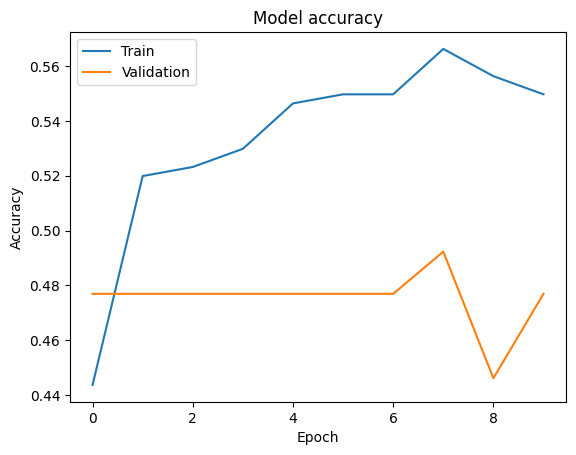

In [108]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

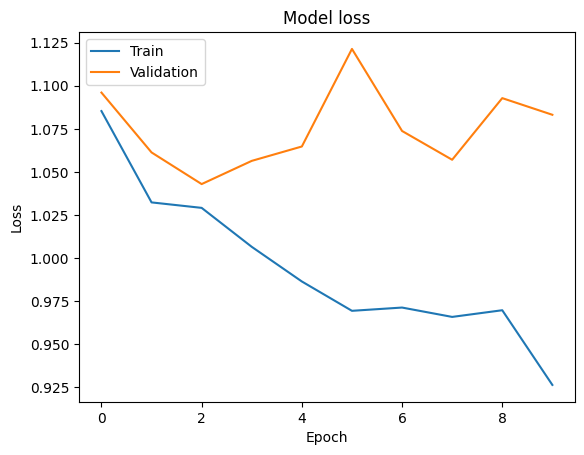

In [109]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [110]:
y_pred_CNN = CNN_model.predict(feature_val)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [111]:
y_pred_label = np.argmax(y_pred_CNN, axis=1)

In [112]:
report=classification_report(y_val,y_pred_label)
print(report)

              precision    recall  f1-score   support

         0.0       0.48      0.94      0.63        31
         1.0       0.50      0.09      0.15        22
         2.0       0.00      0.00      0.00        12

    accuracy                           0.48        65
   macro avg       0.33      0.34      0.26        65
weighted avg       0.40      0.48      0.35        65



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Second Model

In [113]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(1, activation='sigmoid'))
    RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return RNN

In [114]:
RNN_model = create_RNN_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [115]:
RNN_history = RNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.2461 - loss: 0.6589 - val_accuracy: 0.3385 - val_loss: 0.6027
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2598 - loss: 0.7345 - val_accuracy: 0.3385 - val_loss: 0.6057
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2866 - loss: 0.5301 - val_accuracy: 0.3385 - val_loss: 0.6096
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.2435 - loss: 0.6393 - val_accuracy: 0.3385 - val_loss: 0.6599
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.2413 - loss: 0.5596 - val_accuracy: 0.3385 - val_loss: 0.6093
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.2324 - loss: 0.6140 - val_accuracy: 0.3385 - val_loss: 0.6073
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.2694 - loss: 0.6160 - val_accuracy: 0.3385 - val_loss: 0.6186
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.3063 - loss: 0.5220 - val_accuracy: 0.

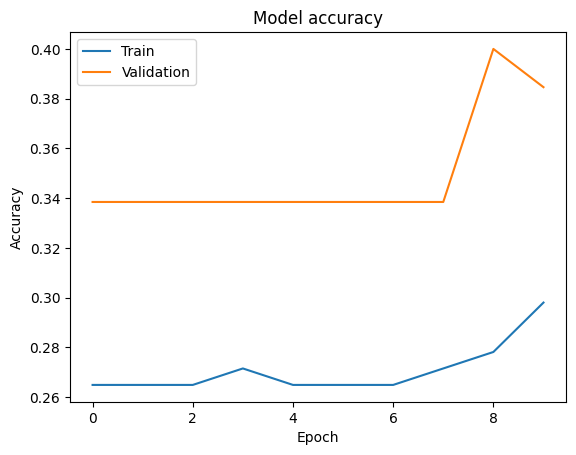

In [116]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## New word2vec

In [158]:
word2vec_new=load_word2vec("/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/word2vec_perso.txt")

In [159]:
#matrix representation of the words in our vocabulary
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
embedding_matrix_new = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_new.get(word)

    if embedding_vector is not None:
        embedding_matrix_new[i] = embedding_vector

## Transform document txt to vector

In [117]:
def document_vector_mean(feature_data, embedding_matrix):
    doc_vectors = []
    for doc in feature_data:
        word_vecs = []
        for idx in doc:
            if idx != 0:
                word_vec = embedding_matrix[idx]
                word_vecs.append(word_vec)
        if word_vecs:
            doc_vector = np.mean(word_vecs, axis=0)
        else:
            doc_vector = np.zeros(embedding_matrix.shape[1])
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)

In [145]:
def document_vector_norm_weighted(feature_data, embedding_matrix):
    doc_vectors = []
    for doc in feature_data:
        word_vecs = [embedding_matrix[idx] for idx in doc if idx != 0]
        if word_vecs:
            word_arr = np.array(word_vecs)
            norms = np.linalg.norm(word_arr, axis=1)
            sum_norms = norms.sum()
            if sum_norms == 0:
                doc_vector = np.mean(word_arr, axis=0)  # Fallback to mean
            else:
                weights = norms / sum_norms
                doc_vector = np.dot(weights, word_arr)
        else:
            doc_vector = np.zeros(embedding_matrix.shape[1])
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)

In [134]:
feature_train_int = feature_train.astype(int)
feature_val_int=feature_val.astype(int)
feature_test_int=feature_test.astype(int)
X_train_vec=document_vector_mean(feature_train_int, embedding_matrix)
X_val_vec=document_vector_mean(feature_val_int, embedding_matrix)
X_test_vec=document_vector_mean(feature_test_int, embedding_matrix)

In [146]:
X_train_vec=document_vector_norm_weighted(feature_train_int, embedding_matrix)
X_val_vec=document_vector_norm_weighted(feature_val_int, embedding_matrix)
X_test_vec=document_vector_norm_weighted(feature_test_int, embedding_matrix)

In [160]:
X_train_vec=document_vector_norm_weighted(feature_train_int, embedding_matrix_new)
X_val_vec=document_vector_norm_weighted(feature_val_int, embedding_matrix_new)
X_test_vec=document_vector_norm_weighted(feature_test_int, embedding_matrix_new)

In [161]:
X_train_vec

array([[-0.44750383,  0.37026596, -0.34806718, ..., -0.38205428,
         0.47057758,  0.44315699],
       [-0.44752743,  0.37135792, -0.34884043, ..., -0.38296987,
         0.47022063,  0.4441273 ],
       [-0.44653239,  0.38247072, -0.35006339, ..., -0.37822236,
         0.47155558,  0.44854794],
       ...,
       [-0.47453237,  0.42779944, -0.40441776, ..., -0.4172078 ,
         0.46346412,  0.44104375],
       [-0.48663736,  0.41558689, -0.40257115, ..., -0.4406291 ,
         0.45782623,  0.44080905],
       [-0.45336651,  0.39563697, -0.37445135, ..., -0.39648682,
         0.47368311,  0.43508588]])

## SVM

In [154]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import uniform, reciprocal

In [155]:
from sklearn.svm import SVC
liner_svm=SVC(kernel="linear",C=0.1,probability=True)
liner_svm.fit(X_train_vec,y_train)

SVC(C=0.1, kernel='linear', probability=True)

In [156]:
svc_val_pred=liner_svm.predict(X_val_vec)

In [157]:
print("\nClassification Report:test set")
print(classification_report(y_val, svc_val_pred))


Classification Report:test set
              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65        31
         1.0       0.00      0.00      0.00        22
         2.0       0.00      0.00      0.00        12

    accuracy                           0.48        65
   macro avg       0.16      0.33      0.22        65
weighted avg       0.23      0.48      0.31        65



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [162]:
param_distributions = {
    'C': reciprocal(0.1, 100),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4],
    'class_weight': [None, 'balanced'],
    'shrinking': [True, False]
}

svm = SVC()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    svm, param_distributions=param_distributions,
    n_iter=50, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42
)
random_search.fit(X_train_vec, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b4ea792e890>,
                                        'class_weight': [None, 'balanced'],
                                        'degree': [2, 3, 4],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1, 1],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'shrinking': [True, False]},
                   random_state=42, scoring='accuracy', verbose=2)

In [163]:
X_trainval_features = np.vstack([X_train_vec, X_val_vec])
y_trainval = np.hstack([y_train, y_val])

final_svm = SVC(**random_search.best_params_)
final_svm.fit(X_trainval_features, y_trainval)

SVC(C=np.float64(65.84106160121607), class_weight='balanced', gamma=1,
    kernel='poly', shrinking=False)

In [164]:
y_test_pred = final_svm.predict(X_test_vec)
y_test_pred

array([1., 0., 2., 2., 0., 0., 1., 2., 1., 1., 0., 2., 2., 1., 1., 1., 1.,
       2., 1., 0., 1., 2., 1., 0., 1., 2., 1., 1., 1., 0., 0., 2., 0., 0.,
       0., 1., 1., 0., 2., 2., 2., 0., 2., 1., 1., 2., 1., 2., 1., 1., 1.,
       1., 2., 1., 0., 0., 2., 1., 1., 0., 2., 1., 0., 1., 2.])

In [166]:
report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.41      0.21      0.27        34
         1.0       0.28      0.42      0.33        19
         2.0       0.26      0.42      0.32        12

    accuracy                           0.31        65
   macro avg       0.32      0.35      0.31        65
weighted avg       0.34      0.31      0.30        65

